<a href="https://colab.research.google.com/github/Pablo-Lemos/orbits/blob/tf2/orbits_tf2_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.4.2"
JULIA_PACKAGES="Optim SpecialFunctions"
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"'
  done

fi

Installing Julia 1.4.2 on the current Colab Runtime...
2021-01-20 10:33:00 URL:https://storage.googleapis.com/julialang2/bin/linux/x64/1.4/julia-1.4.2-linux-x86_64.tar.gz [99093958/99093958] -> "/tmp/julia.tar.gz" [1]
Installing Julia package Optim...
    Cloning default registries into `~/.julia`
    Cloning registry from "https://github.com/JuliaRegistries/General.git"
      Added registry `General` to `~/.julia/registries/General`
  Resolving package versions...
  Installed Artifacts ──────────────────── v1.3.0
  Installed OpenSpecFun_jll ────────────── v0.5.3+4
  Installed DataAPI ────────────────────── v1.4.0
  Installed UnPack ─────────────────────── v1.0.2
  Installed DiffResults ────────────────── v1.0.3
  Installed StatsBase ──────────────────── v0.33.2
  Installed ForwardDiff ────────────────── v0.10.15
  Installed Optim ──────────────────────── v1.2.3
  Installed SortingAlgorithms ──────────── v0.3.1
  Installed OrderedCollections ─────────── v1.3.2
  Installed NLSolversBase

In [2]:
pip install pysr graph_nets "tensorflow_gpu>=2.1.0-rc1" "dm-sonnet>=2.0.0b0" tensorflow_probability

     |████████████████████████████████| 133kB 2.9MB/s 
     |████████████████████████████████| 81kB 5.6MB/s 
     |████████████████████████████████| 394.7MB 44kB/s 
     |████████████████████████████████| 256kB 27.1MB/s 
  Created wheel for graph-nets: filename=graph_nets-1.1.0-cp36-none-any.whl size=91865 sha256=2229f1793c90fdc4d79fe1c1f42dcca5b83c76ef729c35cac7a30fa19e5b42c0
  Stored in directory: /root/.cache/pip/wheels/c9/85/dc/ad3c616f83f0774ff12d6d7599850f56d82976e8590e59e864
Successfully built graph-nets


In [3]:
#@title Imports  { form-width: "30%" }
import numpy as np
import tensorflow as tf
import graph_nets as gn
import sonnet as snt
import matplotlib.pyplot as plt
import math
import gc
import pysr

import os 
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
print(os.chdir('/content/drive/My Drive'))

Mounted at /content/drive
None


In [4]:
#@title Solar system masses  { form-width: "30%" }

''' 
These python lists contain the names and masses of bodies in the solar system. 
All masses here are in kilograms. 

Written by Pablo Lemos (UCL)
pablo.lemos.18@ucl.ac.uk
19-11-2020
'''

sun_mass = 1.9885e+30

planet_names = ['mercury', 
                'venus',
                'earth', 
                'mars',
                'jupiter',
                'saturn', 
                'uranus', 
                'neptune', 
                ]

planet_masses = [0.33011 * 10**24, 
                4.8685 * 10**24,
                5.9724 * 10**24, 
                0.64171 * 10**24,
                1898.19 * 10**24,
                568.34 * 10**24, 
                86.8103 * 10**24, 
                102.41 * 10**24, 
                ]

planets_with_moons = ['earth', 
                #'mars',
                'jupiter',
                'saturn', 
                'uranus', 
                'neptune', 
                ]


earth_moon_names = ['moon']

earth_moon_masses = [0.0734767309 * 10**24]

mars_moon_names = ['phobos', 
                   'deimos']

mars_moon_masses = [1.0659 * 10**16,
                   1.4762 * 10**15
]

jupiter_moon_names = ['io', 
                     'europa', 
                     'ganymede', 
                     'callisto', 
                    ]

jupiter_moon_masses = [0.08931900 * 10**24, 
                            0.048 * 10**24, 
                            0.14819 * 10**24,
                            0.10759 * 10**24]

saturn_moon_names = ['mimas', 
                     'enceladus', 
                     'tethys', 
                     'dione', 
                     'rhea', 
                     'titan', 
                     'hyperion', 
                     'iapetus',
                     'phoebe',
                     ]

saturn_moon_masses = [0.000037493 * 10**24, 
                     0.000108022 * 10**24, 
                     0.000617449 * 10**24, 
                     0.001095452 * 10**24, 
                     0.002306518 * 10**24, 
                     0.1353452 * 10**24, 
                     5.6199 * 10**18, 
                     0.001805635 * 10**24,
                     8.292 * 10**18,
                     ]

uranus_moon_names = ['ariel', 
                     'umbriel', 
                     'titania', 
                     'oberon',
                     'miranda', 
                    ]

uranus_moon_masses = [125100. * 10**16, 
                            127500. * 10**16, 
                            340000. * 10**16,
                            307600. * 10**16,
                            6400.* 10**16,
                            ]

neptune_moon_names = ['triton', 
                      'nereid',
                      'proteus',
                    ]

neptune_moon_masses = [2139000. * 10**16,
                       3.0873 * 10**19,
                       4.4 * 10**19 
]
                            

moon_names = [earth_moon_names, 
                   #mars_moon_names,
                   jupiter_moon_names,
                   saturn_moon_names,
                   uranus_moon_names,
                   neptune_moon_names,
]
        
moon_masses = [earth_moon_masses, 
                   #mars_moon_masses,
                   jupiter_moon_masses,
                   saturn_moon_masses,
                   uranus_moon_masses,
                   neptune_moon_masses,
                   ]



In [5]:
#@title Read orbits  { form-width: "30%" }

''' 
Read NASA planetary orbits, download from https://ssd.jpl.nasa.gov/horizons.cgi#top
with format X, Y, Z, VX, VY, VZ format them, and return two data vectors, one 
containing positions and one containing accelerations. 

For the future: Create a class that contains orbits, names and masses. Will
improve appearance.

Written by Pablo Lemos (UCL)
pablo.lemos.18@ucl.ac.uk
Nov 2020
'''

def read_orbit(name, path):
    ''' Reads the data for a single orbit
    Parameters: 
    -----------
    name: str
        the name of the body
    path: string
        the path to the orbit file

    Returns: 
    --------
    orbit_data : np.array
        a numpy array containing the positions and accelerations for the body 
    '''
    try:
        orbit = np.loadtxt(path+name+'.txt', usecols = [2,3,4,5,6,7], 
                            unpack=True, delimiter=',')
    except IndexError:
        orbit = np.genfromtxt(path+name+'.txt', usecols = [2,3,4,5,6,7], 
                            unpack=True, delimiter=',',
                            skip_header=22, skip_footer = 31
                            )

    return orbit

def add_moons(name, orbits_ls, masses_ls, names_ls, use_moons, path):
    ''' If not using moons, corrects the orbit by changing it to the center 
    of mass of the planet + moons system. Else, add the moons to the list of 
    orbits
    Parameters: 
    -----------
    name: str
        the name of the planet
    orbits_ls : ls
        a list containing the orbits data
    masses_ls : ls
        the masses of all bodies
    names_ls : ls
        the names of all bodies
    use_moons: bool
        whether to treat the moons as separate bodies.
    path: string
        the path to the orbit files

    Returns: 
    --------
    orbits_ls : ls
        a list containing the updated orbits data 
    masses_ls : ls
        the masses of all bodies
    names_ls : ls
        the names of all bodies
    '''   
    # Check if the planets has moons
    if name in planets_with_moons:
        i = planet_names.index(name)
        j = planets_with_moons.index(name)
        for (moon, mass_moon) in zip(moon_names[j],moon_masses[j]):
            orbit_moon = read_orbit(moon, path)
            # If the moons are not being treated as separate bodies, we change
            # the orbit of the planets by the orbit of the Center of Mass of 
            # the planet and orbit system. 
            if use_moons == False:
                #print('Adding data for', moon)
                orbits_ls[-1] += orbit_moon*mass_moon/planet_masses[i]

            # Else, add each moon
            else:
                print('Reading data for', moon)
                orbits_ls.append(orbit_moon)
                masses_ls.append(mass_moon)
                names_ls.append(moon)

    
    return orbits_ls, masses_ls, names_ls


def read_orbits_main(nplanets = 0, 
              use_moons = False, 
              frame = 'b', 
              path = './nasa_orbits/'):
    ''' Reads the data files and returns a numpy array with the orbits 
    Parameters: 
    -----------
    nplanets: int
        the number of planets to be used. If 0, use all the planets. 
        Defaults to 0
    use_moons: bool
        whether to treat the moons as separate bodies. Defaults to False
    frame: str
        The frame of reference to be used. Options are 'b' (barycenter) or 
        's' (sun_center). Defaults to 'barycenter'
    path: string
        the path to the orbit files. It should contain two folders: 'barycenter'
        and 'sun_center'

    Returns: 
    --------
    orbits_data : np.array()
        a numpy array containing the positions and accelerations for each 
        body.
    masses : np.array()
        the masses of all bodies
    names_ls : ls
        the names of all bodies
    '''

    # Modify the path to include the reference frame
    if frame[0]=='b':
        print('Reading data in Solar System barycenter reference frame')
        path += 'barycenter/'
    elif frame[0]=='s':
        print('Reading data in Sun reference frame. Known masses will then be', \
            'used to move to barycenter frame of used bodies. Use this only for', \
            'testing and when few bodies are being used.')
        path += 'sun_center/'    
    else: 
        raise ValueError("frame must be 'b' (barycenter) or 's' (sun_center).")

    # If using the default value for nplanets, we use all 8
    if nplanets == 0: 
        nplanets = 8

    # Read the sun's orbit
    orbit_sun = read_orbit('sun', path)
    # Create a list that will contain all the orbits
    orbits_ls = [orbit_sun]
    # Create a list that will contain all the masses
    masses_ls = [sun_mass]
    names_ls = ['sun']

    for i in range(nplanets):
        name = planet_names[i]
        print('Reading data for', name)
        orbit = read_orbit(name, path)
        orbits_ls.append(orbit)
        masses_ls.append(planet_masses[i])
        names_ls.append(name)
        orbits_ls, masses_ls, names_ls = add_moons(name, orbits_ls, masses_ls,
                                         names_ls, use_moons, path)

    orbits_data = np.stack(orbits_ls)
    # Transpose to get an array with time, planet, axes
    orbits_data = orbits_data.transpose(2,0,1)
    
    # Convert list of masses to numpy array
    masses = np.asarray(masses_ls)

    print('Finished reading data')
    print('The data array contains', len(orbits_data[0]), 'bodies.')

    # If the frame is sub center, need to change things.
    if frame[0] == 's':
        print("Changing frame of reference (this only happens when the data", \
           "is loaded in the Sun's frame). ")
        # Change frame of reference to the barycenter of the planets we are using
        P = masses[np.newaxis, :, np.newaxis]*orbits_data[:,:,3:] 
        V_ref = np.sum(P, axis = 1,keepdims=True)/np.sum(masses)
        orbits_data[:,:,3:] -= V_ref

    return orbits_data, masses, names_ls


                    


In [6]:
#@title Helper functions  { form-width: "30%" }

def log10(x):
    return tf.experimental.numpy.log10(x)

def cartesian_to_spherical_coordinates(point_cartesian, eps=None):
    """Function to transform Cartesian coordinates to spherical coordinates.
    This function assumes a right handed coordinate system with `z` pointing up.
    When `x` and `y` are both `0`, the function outputs `0` for `phi`. Note that
    the function is not smooth when `x = y = 0`.
    Note:
      In the following, A1 to An are optional batch dimensions.
    Args:
      point_cartesian: A tensor of shape `[A1, ..., An, 3]`. In the last
        dimension, the data follows the `x`, `y`, `z` order.
      eps: A small `float`, to be added to the denominator. If left as `None`,
        its value is automatically selected using `point_cartesian.dtype`.
      name: A name for this op. Defaults to `cartesian_to_spherical_coordinates`.
    Returns:
      A tensor of shape `[A1, ..., An, 3]`. The last dimensions contains
      (`r`,`theta`,`phi`), where `r` is the sphere radius, `theta` is the polar
      angle and `phi` is the azimuthal angle.
    """
    #with tf.compat.v1.name_scope(name, "cartesian_to_spherical_coordinates",
    #                             [point_cartesian]):
    #  point_cartesian = tf.convert_to_tensor(value=point_cartesian)

    #shape.check_static(
    #    tensor=point_cartesian,
    #    tensor_name="point_cartesian",
    #    has_dim_equals=(-1, 3))

    x, y, z = tf.unstack(point_cartesian, axis=-1)
    radius = tf.norm(tensor=point_cartesian, axis=-1)
    theta = tf.acos(
        tf.clip_by_value(tf.divide(z, radius), -1., 1.))
    phi = tf.atan2(y, x)
    return tf.stack((log10(radius), theta, phi), axis=-1)

def spherical_to_cartesian_coordinates(point_spherical, name=None):
    """Function to transform Cartesian coordinates to spherical coordinates.
    Note:
      In the following, A1 to An are optional batch dimensions.
    Args:
      point_spherical: A tensor of shape `[A1, ..., An, 3]`. The last dimension
        contains r, theta, and phi that respectively correspond to the radius,
        polar angle and azimuthal angle; r must be non-negative.
      name: A name for this op. Defaults to 'spherical_to_cartesian_coordinates'.
    Raises:
      tf.errors.InvalidArgumentError: If r, theta or phi contains out of range
      data.
    Returns:
      A tensor of shape `[A1, ..., An, 3]`, where the last dimension contains the
      cartesian coordinates in x,y,z order.
    """

    logr, theta, phi = tf.unstack(point_spherical, axis=-1)
    r = tf.pow(10., logr)
    #r = asserts.assert_all_above(r, 0)
    tmp = r * tf.sin(theta)
    x = tmp * tf.cos(phi)
    y = tmp * tf.sin(phi)
    z = r * tf.cos(theta)
    return tf.stack((x, y, z), axis=-1)

def reshape_senders_receivers(senders, receivers, batch_size, nplanets, nedges):
    ''' Reshape receivers and senders to use in graph'''
    x = np.arange(batch_size)
    xx = x.reshape(batch_size,1)
    y = np.ones(nedges)
    z = np.reshape(xx+y-1, batch_size*nedges)*nplanets

    senders = np.concatenate([senders]*batch_size) + z
    receivers = np.concatenate([receivers]*batch_size) + z
    
    return senders, receivers

def build_rotation_matrix(a,b,g):
    A0 = tf.stack([tf.cos(a)*tf.cos(b), tf.sin(a)*tf.cos(b), -tf.sin(b)], 
                  axis=-1)
    A1 = tf.stack([tf.cos(a)*tf.sin(b)*tf.sin(g)-tf.sin(a)*tf.cos(g), 
                   tf.sin(a)*tf.sin(b)*tf.sin(g)+tf.cos(a)*tf.cos(g),
                   tf.cos(b)*tf.sin(g)], axis=-1)
    A2 = tf.stack([tf.cos(a)*tf.sin(b)*tf.cos(g)+tf.sin(a)*tf.sin(g), 
                   tf.sin(a)*tf.sin(b)*tf.cos(g)-tf.cos(a)*tf.sin(g),
                   tf.cos(b)*tf.cos(g)], axis=-1)
    
    return tf.stack((A0, A1, A2), axis=1)

def rotate_data(D, A, uniform = True):
    if uniform:
        n=1
    else:  
        n = D.shape[0]

    # I think the maxes should be 2pi, pi, pi, but going for overkill just in case
    alpha = tf.random.uniform([n,], minval=0, maxval=2*np.pi, dtype=tf.dtypes.float32)
    beta = tf.random.uniform([n,], minval=0, maxval=2*np.pi, dtype=tf.dtypes.float32)
    gamma = tf.random.uniform([n,], minval=0, maxval=np.pi, dtype=tf.dtypes.float32)
    R = build_rotation_matrix(alpha,beta,gamma)
    
    if uniform:
        # Rotate all points by the same angle
        D = tf.linalg.matmul(D,R)
        A = tf.linalg.matmul(A,R)
    else: 
        # Rotate each time step by a different angle:
        D = tf.einsum('nij,njk->nik', D,R)
        A = tf.einsum('nij,njk->nik', A,R)
        
    return D, A

def shuffle_senders_receivers(senders, receivers):
    send_rec = np.stack([senders, receivers], axis = -1)
    n = len(send_rec)
    rands = np.random.uniform(n,)
    new_senders = np.zeros(n,)
    new_receivers = np.zeros(n,)
    signs = np.ones(n,)
    for i in range(len(send_rec)):
        x = np.random.uniform()
        if x>0.5:
            new_senders[i] = senders[i]
            new_receivers[i] = receivers[i]
        else:
            new_senders[i] = receivers[i]
            new_receivers[i] = senders[i]
            signs[i] = -1. 
    return new_senders, new_receivers, signs




In [7]:
#@title ML model  { form-width: "30%" }

class Normalize_gn(tf.keras.layers.Layer):
    def __init__(self, D):
        super(Normalize_gn, self).__init__()
        self.maxs_r = tf.reduce_max(D[:,:1], axis = 0)
        self.mins_r = tf.reduce_min(D[:,:1], axis = 0)
        
    def call(self, inputs):
        maxs_r = self.maxs_r
        mins_r = self.mins_r
        maxs_theta = tf.constant([np.pi])
        maxs_phi = tf.constant([np.pi])
        mins_theta = tf.constant([0.])
        mins_phi = tf.constant([-np.pi])
        maxs_m = tf.constant([12.])
        mins_m = tf.constant([-12.])

        maxs = tf.concat([maxs_r, maxs_theta, maxs_phi, maxs_m, maxs_m], axis = -1)
        mins = tf.concat([mins_r, mins_theta, mins_phi, mins_m, mins_m], axis = -1)

        X = (inputs - mins)/(maxs-mins)
        outputs = 2*X - 1
    
        return outputs

def mean_weighted_error(y_true, y_pred, nplanets):
    y_true = tf.reshape(y_true, shape=[-1, nplanets, 3])
    y_pred = tf.reshape(y_pred, shape=[-1, nplanets, 3])

    mag_true = tf.norm(y_true, axis=-1)
    mag_true = tf.reduce_mean(mag_true, axis = 0)

    mag_pred = tf.norm(y_pred, axis=-1)
    mag_pred = tf.reduce_mean(mag_pred, axis = 0)

    weights = tf.abs(log10(mag_true) - log10(mag_pred))
    ones = tf.ones(shape=[nplanets,])
    weights = tf.maximum(weights, ones)
    
    x = (y_pred - y_true)/tf.norm(y_true, axis = -1, keepdims=True)
    x = tf.norm(x, axis=-1)
    loss = tf.reduce_mean(x, axis = 0)
    loss = tf.reduce_mean(loss*weights)    
    
    return loss

class MeanWeightedError(tf.keras.metrics.Metric):
    def __init__(self, name="mean_weighted_error", **kwargs):
        super(MeanWeightedError, self).__init__(name=name, **kwargs)
        self.mwe = self.add_weight(name="mwe", initializer="zeros")

    def update_state(self, y_true, y_pred, nplanets):
        self.mwe.assign_add(mean_weighted_error(y_true, y_pred, nplanets))

    def result(self):
        return self.mwe

    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        self.mwe.assign(0.0)

loss_tracker = tf.keras.metrics.Mean(name='loss')
loss_test = MeanWeightedError(name='loss_test')

class LearnForces(tf.keras.Model):
    def __init__(self, nplanets, senders, receivers, norm_layer, noise_level = 0.):
        super(LearnForces, self).__init__()
        self.noise_level = noise_level
        self.senders = senders
        self.receivers = receivers
        self.nplanets = nplanets
        self.nedges = nplanets*(nplanets-1)//2

        self.opt1 = tf.keras.optimizers.Adam(learning_rate=5e-2)
        self.opt2 = tf.keras.optimizers.Adam(learning_rate=1e-3)
        
        logm_init = tf.random_normal_initializer(mean=0.0, stddev=5.0)
        
        self.logm_planets = tf.Variable(
            initial_value=logm_init(shape=(self.nplanets,), dtype="float32"),
            trainable=True,
            constraint=lambda z: tf.clip_by_value(z, -12, 12)
        )
        
        #norm_layer = Normalize_gn()
        
        self.graph_network = gn.blocks.EdgeBlock(
            edge_model_fn = lambda: snt.Sequential([
                                                  norm_layer,
                                                  tf.keras.layers.Dense(128, input_dim=6, kernel_initializer='normal', activation='tanh'),
                                                  tf.keras.layers.Dense(128, activation='tanh'),
                                                  tf.keras.layers.Dense(128, activation='tanh'),
                                                  snt.Linear(3),
                                                            ]),
            use_edges = True,
            use_receiver_nodes = True,
            use_sender_nodes = True,
            use_globals = False,
        )
                


    def sum_forces(self, graph):
        b1_tr = gn.blocks.ReceivedEdgesToNodesAggregator(reducer = tf.math.unsorted_segment_sum)(graph)
        b2_tr = gn.blocks.SentEdgesToNodesAggregator(reducer = tf.math.unsorted_segment_sum)(graph)
        summed_forces = b1_tr-b2_tr
        return summed_forces
            
    def get_acceleration(self, forces, graph):
        acceleration_tr = tf.divide(forces, tf.pow(10.,graph.nodes))
        return acceleration_tr
        
    def call(self, D, training = False, extract = False):
        ntime = len(D)//self.nedges
        if training == True:
            m_noise = tf.random.normal(tf.shape(self.logm_planets), 0, self.noise_level, tf.float32)
            lm = self.logm_planets*(1+ m_noise)
        else: 
            lm = self.logm_planets
            
        lm = tf.clip_by_value(lm, -12, 12, name=None)
        self.logmasses = lm

        nodes_g = tf.concat([lm]*ntime, axis = 0)
        nodes_g = tf.expand_dims(nodes_g, 1)
        senders_g, receivers_g = reshape_senders_receivers(self.senders, 
                                                             self.receivers, 
                                                             ntime, 
                                                             self.nplanets, 
                                                             self.nedges)
        
        if training == True:
            senders_g, receivers_g, signs = shuffle_senders_receivers(senders_g, 
                                                                  receivers_g)
            D=D*signs[:,np.newaxis]
        
        # Create graph
        graph_dict = { 
          "nodes": nodes_g,
          "edges": cartesian_to_spherical_coordinates(D), 
          "receivers": receivers_g, 
          "senders": senders_g ,
          #"globals": self.logG
           } 
        
        # This step takes order 10 times longer than any other in this function
        g = gn.utils_tf.data_dicts_to_graphs_tuple([graph_dict])
        g = self.graph_network(g)
        g = g.replace(
            edges = spherical_to_cartesian_coordinates(g.edges))
        f = self.sum_forces(g)

        a = self.get_acceleration(f, g)
        if extract == True: 
            f = tf.reshape(g.edges, shape=[-1, self.nedges, 3]).numpy()
            a = tf.reshape(a, shape=[-1, self.nplanets, 3]).numpy()
            return a, f
        else: 
            return a
    
    def train_step(self, data):
        #if isinstance(data, tuple):
        #    data = data[0]

        # Unpack the data
        D, A = data
        
        D_rs = tf.reshape(D, shape = [-1, self.nedges, 3])
        A_rs = tf.reshape(A, shape = [-1, self.nplanets, 3])
        D_rot, A_rot = rotate_data(D_rs, A_rs, uniform = False)
        D_rot = tf.reshape(D_rot, shape = [-1, 3])
        A_rot = tf.reshape(A_rot, shape = [-1, 3])
        
        D_noise = tf.random.normal(tf.shape(D), 0, self.noise_level, tf.float32)
        D_rot = D_rot*(1+ D_noise)

        # Randomly 3D rotate the data
        
        with tf.GradientTape() as tape:
            # Forward pass
            predictions = self(D_rot, training = True)
            # Compute the loss
            loss = mean_weighted_error(A_rot, predictions, self.nplanets)
        
        # Compute gradients
        # Trainable variables are the masses and the MLP layers 
        #Trainable_vars = self.trainable_variables+ list(self.graph_network.trainable_variables)
        #gradients = tape.gradient(loss, trainable_vars)
        #gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
        # Update weights
        #self.optimizer.apply_gradients(zip(gradients,trainable_vars))


        var_list1 = self.trainable_variables
        var_list2 = list(self.graph_network.trainable_variables)
        gradients = tape.gradient(loss, var_list1 + var_list2)
        grads1 = gradients[:len(var_list1)]
        grads2 = gradients[len(var_list1):]
        #grads1, _ = tf.clip_by_global_norm(grads1, 5.0)
        #grads2, _ = tf.clip_by_global_norm(grads2, 5.0)
        train_op1 = self.opt1.apply_gradients(zip(grads1, var_list1))
        train_op2 = self.opt2.apply_gradients(zip(grads2, var_list2)) 
        train_op = tf.group(train_op1, train_op2)        
        
        loss_tracker.update_state(loss)
        return {"loss": loss_tracker.result()}

    def test_step(self,data):
        # Unpack the data
        D, A = data
        
        predictions = self(D)

        loss_test.update_state(A, predictions, self.nplanets)
        
        return {"loss": loss_test.result()}
    
    @property
    def metrics(self):
        # We list our `Metric` objects here so that `reset_states()` can be
        # called automatically at the start of each epoch
        # or at the start of `evaluate()`.
        # If you don't implement this property, you have to call
        # `reset_states()` yourself at the time of your choosing.
        return [loss_tracker, loss_test]


In [8]:
#@title Prepare data  { form-width: "30%" }
# Global constants
AU = 149.6e6 * 1000 # Astronomical Unit in meters.
DAY = 24*3600. # Day in seconds
YEAR = 365.25*DAY #Year
delta_time = (0.5/24.) # 2 hours
MSUN = 1.9885e+30
MEARTH = 5.9724e+24
G = 6.67428e-11/AU**3*MSUN*DAY**2

def force_newton(x, m1, m2):
    return G*m1*m2/np.linalg.norm(x, axis = -1, keepdims=True)**3.*x


# Training variables
patience = 5
d_patience = 0
noise_level = 0.01
log_every_iterations = 1000
num_training_iterations = 200000

# Do not change this
#total_time_traj = 35 #Years
#num_time_steps_total = int(total_time_traj/delta_time)
num_time_steps_tr = 520000 #An orbit for saturn is 129110 steps
num_time_steps_sr = 500
#num_batches = 13000
batch_size_tr = 32#num_time_steps_tr//num_batches
num_batches = num_time_steps_tr//batch_size_tr

def force_newton(x, m1, m2):
    return G*m1*m2/np.linalg.norm(x, axis = -1, keepdims=True)**3.*x

nplanets = 8 # Number of planets (not counting the sun)
data, masses, names = read_orbits_main(nplanets = nplanets, frame='b', use_moons = True, 
                                       path='/content/drive/MyDrive/')
nplanets = len(data[0])
nedges = nplanets*(nplanets-1)//2
batch_size_tr = num_time_steps_tr//num_batches

print('Formatting data')

# Get the acceleration
A = data[1:,:,3:] - data[:-1,:,3:]
data[:-1, :, 3:] = A/delta_time 
data = data[:-1]

# For debugging, reduce size of validation data. Really speeds things up!
nval = 10000
data = data[:(num_time_steps_tr + nval)]

masses/=MSUN

# Split into training and validation
data_tr = data[:num_time_steps_tr]
data_val = data[num_time_steps_tr:]

num_time_steps_tr = 130000
data_tr = data_tr[:num_time_steps_tr]

num_time_steps_val = len(data_val)

# Shuffle the data
np.random.shuffle(data_tr)
np.random.shuffle(data_val)

num_time_steps_tr = 130000
data_tr = data_tr[:num_time_steps_tr]

D_tr_np = np.empty([len(data_tr), nedges, 3])
D_val_np = np.empty([len(data_val), nedges, 3])
F_val = np.empty([len(data_val), nedges, 3])
k=0
names_edges = []
senders, receivers = [], []
for i in range(nplanets):
    for j in range(nplanets):
        if i > j:
            d_tr = data_tr[:,j,:3] - data_tr[:,i,:3]
            d_val = data_val[:,j,:3] - data_val[:,i,:3]
            D_tr_np[:,k,:] = d_tr
            D_val_np[:,k,:] = d_val 
            F_val[:,k,:] = force_newton(d_val, masses[i], masses[j]) 
            names_edges.append(names[j] + ' - ' + names[i])
            k+=1 
            receivers.append(i)
            senders.append(j)

A_tr = data_tr[:,:,3:]
A_val = data_val[:,:,3:]
A_norm =np.std(A_tr) 

D_tr_flat = np.reshape(D_tr_np, [num_time_steps_tr*nedges, 3])
D_val_flat = np.reshape(D_val_np,[1, num_time_steps_val*nedges, 3])

A_tr_flat = np.reshape(A_tr/A_norm, [num_time_steps_tr*nplanets, 3])
A_val_flat = np.reshape(A_val/A_norm, [1, num_time_steps_val*nplanets, 3])

D_tr = tf.convert_to_tensor(D_tr_flat, dtype="float32")
A_tr = tf.convert_to_tensor(A_tr_flat, dtype="float32")

D_tr_batches = tf.split(D_tr,  num_batches)
A_tr_batches = tf.split(A_tr,  num_batches)

D_val = tf.convert_to_tensor(D_val_flat, dtype="float32")
A_val = tf.convert_to_tensor(A_val_flat, dtype="float32")

train_ds = tf.data.Dataset.from_tensor_slices(
    (D_tr_batches, A_tr_batches))

test_ds = tf.data.Dataset.from_tensor_slices(
    (D_val, A_val))

norm_layer = Normalize_gn(cartesian_to_spherical_coordinates(D_tr))

print('Cleaning memory')
A_tr = None
A_val = None
D_tr = None
A_tr_flat = None
A_val_flat = None
D_tr_flat = None
A_tr_batches = None
D_tr_batches = None
data = None
data_tr = None
gc.collect()


Reading data in Solar System barycenter reference frame
Reading data for mercury
Reading data for venus
Reading data for earth
Reading data for moon
Reading data for mars
Reading data for jupiter
Reading data for io
Reading data for europa
Reading data for ganymede
Reading data for callisto
Reading data for saturn
Reading data for mimas
Reading data for enceladus
Reading data for tethys
Reading data for dione
Reading data for rhea
Reading data for titan
Reading data for hyperion
Reading data for iapetus
Reading data for phoebe
Reading data for uranus
Reading data for ariel
Reading data for umbriel
Reading data for titania
Reading data for oberon
Reading data for miranda
Reading data for neptune
Reading data for triton
Reading data for nereid
Reading data for proteus
Finished reading data
The data array contains 31 bodies.
Formatting data
Cleaning memory


0

In [9]:
#@title Training  { form-width: "30%" }

checkpoint_filepath = '/content/drive/MyDrive/saved'

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                            verbose = 1,
                                            patience=10,
                                            #baseline = 0.1,
                                            restore_best_weights=False)
# Restore best weights not working, but found way around using checkpoint

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                 save_weights_only=False,
                                                save_best_only=True,
                                                 verbose=0)
model = LearnForces(nplanets, senders, receivers, norm_layer, noise_level = noise_level)

#model.compile(run_eagerly=True)
model.compile()

'''
print('Starting model training')
model.fit(train_ds, 
          epochs = 1000, 
          verbose=2,
          callbacks=[early_stopping, checkpoint], 
          validation_data=test_ds
         )

print('Model training completed')
'''
model.load_weights(checkpoint_filepath)

model.evaluate(test_ds)

j=0
learned_masses = model.logm_planets.numpy() - model.logm_planets.numpy()[0]
print('name, true log mass, learned log mass')
for i in range(nplanets):
    print(f'{names[i]}, {np.log10(masses[i]/masses[j]):.2f}, {learned_masses[i]:.2f}, {abs(np.log10(masses[i]/masses[j]) -learned_masses[i])/abs(np.log10(masses[i])):.2f}')

test_ds = None
train_ds = None
gc.collect()

1/1 [==============================] - 41s 41s/step - loss: 0.0293
name, true log mass, learned log mass
sun, 0.00, 0.00, nan
mercury, -6.78, -9.87, 0.46
venus, -5.61, -9.37, 0.67
earth, -5.52, -5.59, 0.01
moon, -7.43, -9.10, 0.22
mars, -6.49, -8.69, 0.34
jupiter, -3.02, -3.02, 0.00
io, -7.35, -7.40, 0.01
europa, -7.62, -7.51, 0.01
ganymede, -7.13, -7.21, 0.01
callisto, -7.27, -7.36, 0.01
saturn, -3.54, -3.53, 0.00
mimas, -10.72, -10.10, 0.06
enceladus, -10.27, -9.81, 0.04
tethys, -9.51, -9.25, 0.03
dione, -9.26, -9.17, 0.01
rhea, -8.94, -8.82, 0.01
titan, -7.17, -7.23, 0.01
hyperion, -11.55, -8.13, 0.30
iapetus, -9.04, -7.36, 0.19
phoebe, -11.38, -7.09, 0.38
uranus, -4.36, -4.35, 0.00
ariel, -9.20, -9.28, 0.01
umbriel, -9.19, -9.18, 0.00
titania, -8.77, -8.79, 0.00
oberon, -8.81, -8.90, 0.01
miranda, -10.49, -10.28, 0.02
neptune, -4.29, -4.28, 0.00
triton, -7.97, -7.97, 0.00
nereid, -10.81, -7.32, 0.32
proteus, -10.66, -10.63, 0.00


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars


8

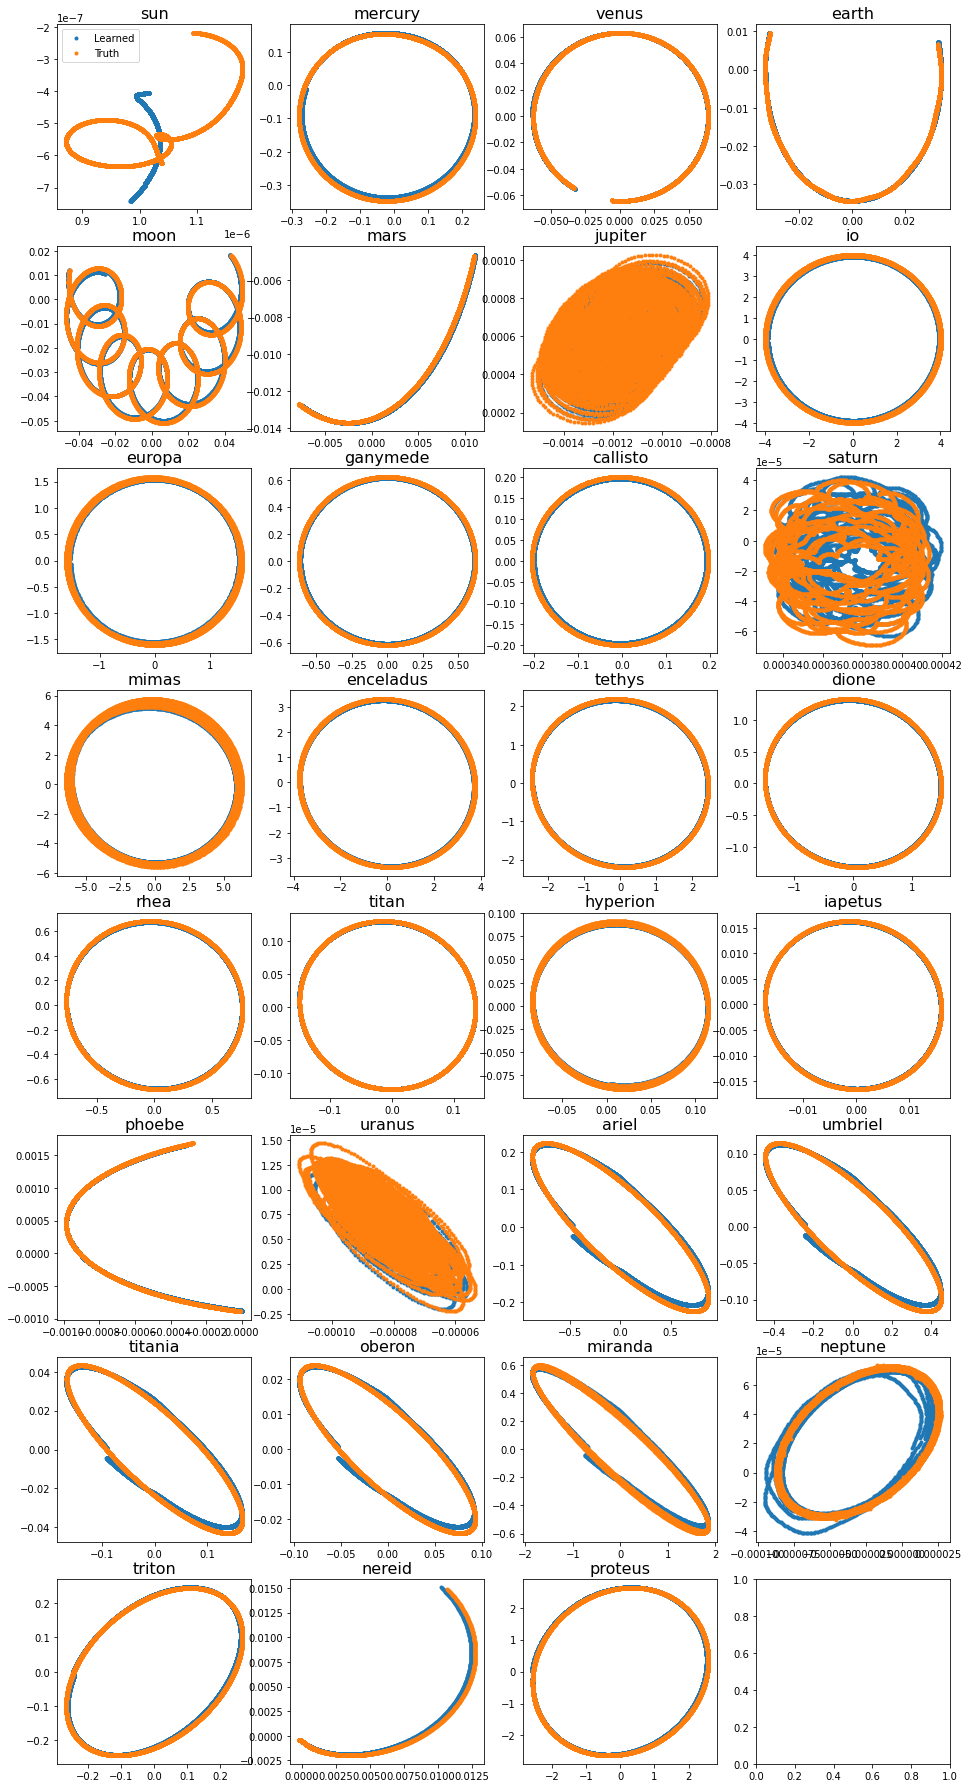

In [10]:
#@title Plot results { form-width: "30%" }

ap ,fp = model(D_val_flat[0], extract = True)

nrows = math.ceil(nplanets/4)
fig, ax = plt.subplots(nrows, 4, figsize = (16, 4*nrows))
for i in range(nplanets):
    ax[i//4, i%4].set_title(names[i], fontsize = 16)
    ax[i//4, i%4].plot(ap[:,i,0], ap[:,i,1], '.', label = 'Learned')
    ax[i//4, i%4].plot(data_val[:,i,3]/A_norm, data_val[:,i,4]/A_norm, '.', label = 'Truth')

ax[0,0].legend()
plt.savefig('./learned_orbits.png')

In [12]:
#@title Symbolic Regression  { form-width: "30%" }

X = np.zeros([nval, nedges,9])
X[:,:,2:5] = D_val_np
X[:,:,5] = np.linalg.norm(D_val_np, axis = -1)
X[:,:,6:] = fp
k=0
for i in range(nplanets):
    for j in range(nplanets):
        if i > j:
            X[:,k,0] = 10**(learned_masses[i])
            X[:,k,1] = 10**(learned_masses[j])
            #print(fp[0,k,0], X[0,k,0]*X[0,k,1]*X[0,k,2]/X[0,k,5]**3.)
            k+=1 
            
X[:,:,2:5], X[:,:,6:] = rotate_data(X[:,:,2:5], X[:,:,6:], uniform = False)

X = np.reshape(X, [nval*nedges,9])
#X = X[np.linalg.norm(X[:,6:], axis = -1)>-1e10]
np.random.shuffle(X)

y = X[:,6] #F_x
#X[:, [0, 1]] = np.exp(X[:, [0, 1]])/1e23 #re-scale to prevent precision issues, since pysr uses 32-bit floats
y /= np.mean(abs(y))                                 #same as above

print('Normalization constant:',np.mean(abs(y))*A_norm/10**(model.logm_planets.numpy()[0]))

equations = pysr.pysr(X[:10000,:6], y[:10000],
     #equation_file = '/Users/Pablo/Desktop/equation_files/equation_file.csv',
     niterations=20, populations=50,
     parsimony=0.0, procs=4, maxsize=20,
     variable_names = ['m0', 'm1', 'x', 'y', 'z', 'r'],
     unary_operators=['square', 'cube'],
     binary_operators=["mult", 'div'],
     #constraints={'pow': (3, 3)}
)



pysr.best(equations)

Normalization constant: 2.3193854573088382e-06
Running on julia -O3 -p 4 /tmp/tmpc4f9_51w/runfile.jl
Started!

Cycles per second: 1.220e+05
Progress: 27 / 1000 total iterations (2.700%)
Hall of Fame:
-----------------------------------------
Complexity  MSE        Score     Equation
0           4.321e+02  0.000e+00  0.283101
3           4.318e+02  2.794e-04  mult(m1, 0.97454596)
4           4.303e+02  3.457e-03  mult(square(m1), x)
5           4.298e+02  1.015e-03  mult(mult(x, m1), 0.6985264)
6           4.298e+02  -0.000e+00  mult(mult(x, square(m1)), 0.6985264)
7           4.103e+02  4.654e-02  mult(mult(div(x, r), m1), 34.03827)
9           1.216e+02  6.079e-01  mult(mult(mult(mult(m0, m1), -0.71839714), x), -152585.1)
11          1.216e+02  4.172e-07  mult(mult(mult(mult(m0, m1), mult(m1, -0.71839714)), x), -152585.1)
12          7.720e+01  4.547e-01  mult(cube(mult(mult(x, 2071.0212), mult(mult(m0, m1), 1.0200547))), m1)
13          1.040e+01  2.004e+00  mult(square(div(div(div(m

19701584.1867877*m0*m1*x/r**3

In [13]:
pysr.best(equations)

19701584.1867877*m0*m1*x/r**3